# DBSCAN Model Training

In [0]:
import numpy as np
import pandas as pd
import math

import json

import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.spatial.distance import cdist

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit, udf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

from sklearn.cluster import DBSCAN
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors


In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

# Data Partitioning

Since DBScan doesn't have a native implementation in MLLib, in order to do a parallel version we have to **partition the dataset**, **apply DBSCAN to each partition independently**, and then join the results.

Although this naive implementation could easily raise problems when clustering (for example, different partitions identifying the same clusters but giving them different labels, and so the concatenated results would look way off), in this case, the negative implications are reduced, since our problem is of outlier detection -- we are only looking for points labeled as noise (cluster -1).

The negative implications still present are that, by partitioning the dataset, each partition becomes scarser: and so points that could otherwise be identified as core points no longer are, reducing the reach of the cluster and identifying more points as outlier points. However, we believe this can be easily mitigated by just adjusting the parameter of "necessary neighbors to become a core point" according to the number of partitions; and general adjustment of parameters.

Due to this, it is not recommended to use a number of partitions too high, as that could lead to greater sparsity in points and thus increase the number of data points incorrectly (compared to a non-partitioned DBSCAN) identified as anomalous weather events.

In [0]:
# Define number of partitions. 2-4 would be reasonable, while not disturbing dbscan results too much
num_partitions = 2

In [0]:
# Load selected features
feature_cols_json = dbutils.fs.head("dbfs:/tmp/feature_cols.json")
feature_cols = json.loads(feature_cols_json)
feature_cols

Out[37]: ['temperature_2m', 'precipitation', 'wind_gusts_10m', 'cloud_cover']

In [0]:
# Load data from DBFS
sdf = spark.table("historical_weather_hourly_lisbon")
display(sdf)

org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 68.0 failed 1 times, most recent failure: Lost task 0.0 in stage 68.0 (TID 179) (ip-10-172-229-2.us-west-2.compute.internal executor driver): com.databricks.sql.io.FileReadException: Error while reading file dbfs:/user/hive/warehouse/historical_weather_hourly_lisbon/part-00006-tid-4916017374104956254-52386b06-5bb2-47eb-882d-3bec6b974b76-17-1-c000.snappy.parquet. [DEFAULT_FILE_NOT_FOUND] It is possible the underlying files have been updated. You can explicitly invalidate the cache in Spark by running 'REFRESH TABLE tableName' command in SQL or by recreating the Dataset/DataFrame involved. If disk cache is stale or the underlying files have been removed, you can invalidate disk cache manually by restarting the cluster.
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1$$anon$2.logFileNameAndThrow(FileScanRDD.scala:704)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1$$anon$2.getNext(FileScanRDD.scala:646)
	at org.apache.spark.util.NextIterator.hasNext(NextIterator.scala:73)
	at org.apache.spark.sql.execution.datasources.FileScanRDD$$anon$1.$anonfun$prepareNextFile$1(FileScanRDD.scala:879)
	at scala.concurrent.Future$.$anonfun$apply$1(Future.scala:659)
	at scala.util.Success.$anonfun$map$1(Try.scala:255)
	at scala.util.Success.map(Try.scala:213)
	at scala.concurrent.Future.$anonfun$map$1(Future.scala:292)
	at scala.concurrent.impl.Promise.liftedTree1$1(Promise.scala:33)
	at scala.concurrent.impl.Promise.$anonfun$transform$1(Promise.scala:33)
	at scala.concurrent.impl.CallbackRunnable.run(Promise.scala:64)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingRunnable.$anonfun$run$1(SparkThreadLocalForwardingThreadPoolExecutor.scala:116)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at com.databricks.spark.util.IdentityClaim$.withClaim(IdentityClaim.scala:48)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingHelper.$anonfun$runWithCaptured$4(SparkThreadLocalForwardingThreadPoolExecutor.scala:79)
	at com.databricks.unity.UCSEphemeralState$Handle.runWith(UCSEphemeralState.scala:41)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingHelper.runWithCaptured(SparkThreadLocalForwardingThreadPoolExecutor.scala:78)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingHelper.runWithCaptured$(SparkThreadLocalForwardingThreadPoolExecutor.scala:64)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingRunnable.runWithCaptured(SparkThreadLocalForwardingThreadPoolExecutor.scala:113)
	at org.apache.spark.util.threads.SparkThreadLocalCapturingRunnable.run(SparkThreadLocalForwardingThreadPoolExecutor.scala:116)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
Caused by: java.io.FileNotFoundException: /user/hive/warehouse/historical_weather_hourly_lisbon/part-00006-tid-4916017374104956254-52386b06-5bb2-47eb-882d-3bec6b974b76-17-1-c000.snappy.parquet
	at com.databricks.backend.daemon.data.client.DbfsClient.send0(DbfsClient.scala:121)
	at com.databricks.backend.daemon.data.client.DbfsClient.sendIdempotent(DbfsClient.scala:69)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystemV1.getFileStatus(DatabricksFileSystemV1.scala:272)
	at com.databricks.backend.daemon.data.client.DatabricksFileSystem.getFileStatus(DatabricksFileSystem.scala:212)
	at com.databricks.spark.metrics.FileSystemWithMetrics.getFileStatus(FileSystemWithMetrics.scala:399)
	at com.databricks.sql.io.parquet.CachingParquetFooterReader.readFooter(CachingParquetFooterReader.java:203)
	at com.databricks.sql.io.parquet.CachingParquetFileReader.readFooter(CachingParquetFileReader.java:412)
	at org.apache.spark.sql.execution.datasources.parquet.SpecificParquetRecordReaderBase.prepare(SpecificParquetRecordReaderBase.java:157)
	at org.apache.spark.

In [0]:

partitioned_sdf = sdf.repartition(num_partitions)

# Determining parameters for DBSCAN

We need to decide on parameters `eps` and `min_samples`

Several websites cite Sander et al., 1998, for a good heuristic for `min_samples` of 2*D, with D being the number of dimensions (features), with recommendations for using higher min_samples when dealing with a large dataset and/or noisy data.

As for `eps`, we will plot the distance of each point to its k nearest neighbors (with k = min_samples) in ascending order, to determine the distance that corresponds to the elbow, i.e., at which value do extreme points' distance start blowing up. This is generally a good approximator for `eps`, as it captures the distance to most points while excluding outliers.


In [0]:
min_samples = 2*len(feature_cols)
print("min_samples =", min_samples)

min_samples = 12


In [0]:
# Converting to normal python code to do plots that help us understand this problem in particular,
# as different feature combinations may require different parameters for the DBSCAN

# In this case since we have ~9000 rows, it is not problematic to use all the rows.
# We sample by 1/num_partitions (=0.5) to simulate the general density of the data when partitioned
# If we were analyzing data from more years; and/or using significantly more features, it would be wise to sample further the dataset to do these tests, but further attention would have to be given to the aforementioned problems.

sample_pdf = sdf.select("features_scaled")\
                       .sample(fraction=1/num_partitions, seed=42)\
                       .toPandas()
# Convert each Vector into a NumPy array of length 6
X_sample = np.vstack(sample_pdf["features_scaled"].map(lambda v: v.toArray()))


/databricks/spark/python/pyspark/sql/pandas/conversion.py:122: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field features_scaled. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


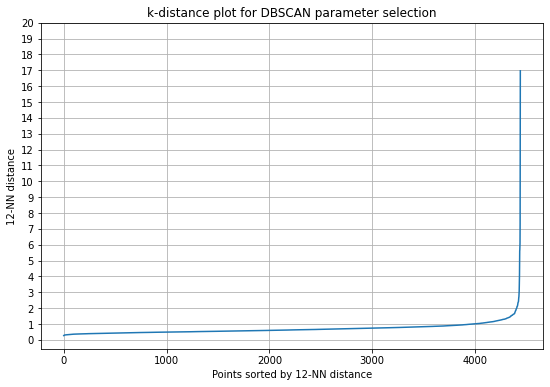

In [0]:

k = min_samples
nbrs = NearestNeighbors(n_neighbors=k, algorithm="auto").fit(X_sample)
distances, _ = nbrs.kneighbors(X_sample)
# distances[i, j] is the distance from point i to its j-th nearest neighbor
# We want the distance to the k-th neighbor (index k-1, because index 0 is itself)
k_distances = np.sort(distances[:, k-1])  # sorted ascending

plt.figure(figsize=(9,6))
plt.plot(range(len(k_distances)), k_distances)
plt.xlabel(f"Points sorted by {k}-NN distance")
plt.ylabel(f"{k}-NN distance")
plt.yticks([i for i in range(21)])
plt.title("k-distance plot for DBSCAN parameter selection")
plt.grid(True)
plt.show()


Given the plot, 1.5 seems like an appropriate distance for `eps`.

# Application of DBSCAN

In [0]:
# Defined in the previous section
min_samples = 12
eps = 1.5

In [0]:
# Adapting function from class that applies DBSCAN to each partition. We include the time to serve as a reference to each row.
def dbscan_partition(iterator, eps, min_samples):
    """
    Expects each record to be ((time,), scaled_array),
    runs DBSCAN on the scaled arrays within one partition,
    and returns (time, cluster_label) for each point.
    """
    rows = list(iterator)
    if not rows:
        return iter([])

    # Split into parallel lists: times and scaled feature vectors
    times, scaled_pts = zip(*[(orig[0], scaled) for orig, scaled in rows])
    X = np.vstack(scaled_pts)   # shape = (n_points_in_partition, n_features)

    # Run sklearn's DBSCAN on this partition's scaled data
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_         # array of length = number of points in this partition

    # Return an iterator of (time, label) tuples
    return iter([(times[i], int(labels[i])) for i in range(len(times))])

In [0]:
# Applying DBSCAN on the partitions
# Build an RDD of ((time,), scaled_array) for each row
rdd_input = partitioned_sdf.rdd.map(
    lambda row: (
        (row["time"],),               # orig tuple contains only "time"
        row["features_scaled"].toArray()
    )
)
# Run DBSCAN inside each partition
result_rdd = rdd_input.mapPartitions(lambda it: dbscan_partition(it, eps=eps, min_samples=min_samples))

In [0]:
# Converting the results into a sdf
clusters_df = result_rdd.toDF(["time", "cluster"])

# Creating an "is_anomaly" column in line with other notebooks
clusters_df = clusters_df.withColumn(
    "is_anomaly",
    when(col("cluster") == -1, 1).otherwise(0)
)

# Add the "is_anomaly" and "cluster" columns to the original sdf, by left joining on time
sdf = sdf.join(
    clusters_df.select("time", "cluster", "is_anomaly"),
    on="time",
    how="left"
)

In [0]:
sdf.select("time", "cluster", "is_anomaly").show(10)

+----------------+-------+----------+
|            time|cluster|is_anomaly|
+----------------+-------+----------+
|2025-01-30T16:00|      0|         0|
|2025-01-30T12:00|      0|         0|
|2025-01-30T17:00|      0|         0|
|2025-01-30T22:00|      0|         0|
|2025-01-30T14:00|      0|         0|
|2025-01-30T15:00|      0|         0|
|2025-01-30T19:00|      0|         0|
|2025-01-30T13:00|      0|         0|
|2025-01-30T21:00|      0|         0|
|2025-01-30T20:00|      0|         0|
+----------------+-------+----------+
only showing top 10 rows



# Year-round visualization

In [0]:
# Selection of relevant columns and conversion to pandas for visualization
plot_df = sdf.select(
    feature_cols + ["time","is_anomaly"]
).orderBy("time").toPandas()

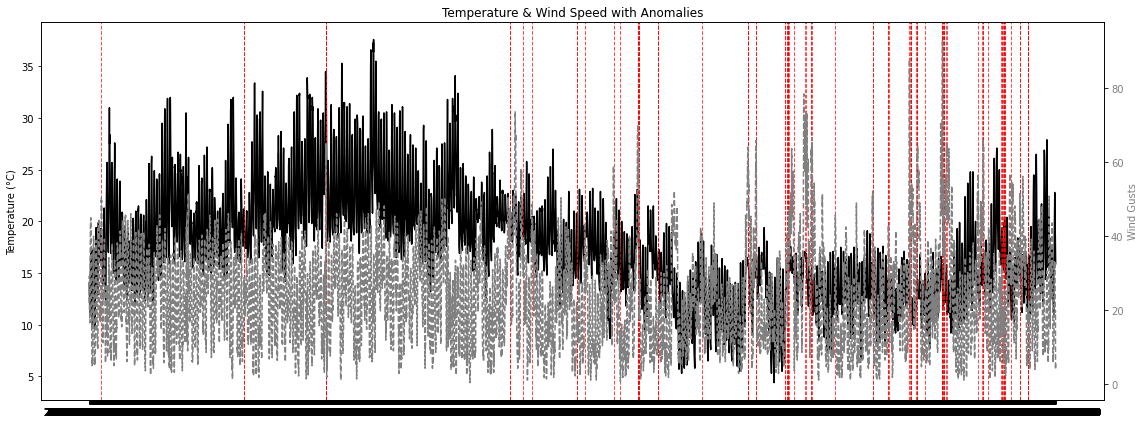

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

feat1 = feature_cols[0]
feat2 = feature_cols[1]

# Plot feat1 as a line
ax1.plot(plot_df["time"], plot_df[feat1], color="black", label=feat1)
ax1.set_ylabel(feat1, color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Secondary axis for feat2
ax2 = ax1.twinx()
ax2.plot(plot_df["time"], plot_df[feat2], color="gray", linestyle='--', label=feat2)
ax2.set_ylabel(feat2, color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# Title and legend
plt.title(feat1 + "&" feat2 + "with Anomalies")
fig.tight_layout()
plt.show()

# Saving the model so it can be used for new data (Streaming)

In order to futurely detect whether new data points are outliers or not, we have to dig a bit deep into the DBSCAN functioning.

To determine whether a new point would be an outlier, we have to:
- obtain coordinates of all core-points
- check if new point is within an epsilon neighborhood of any core point

However, out of all points that belong to a cluster, there is no way to directly access which are core points, and which are edge points (picked up by core points). To simplify the implementation and as a reasonable approximation, we will consider both categories as core points -- a small limitation that makes this slightly different from the exact DBSCAN functioning, but that achieves similar results.

In [0]:

# We'll treat every non-noise point (cluster != -1) as a “core‐region” prototype.
core_points_df = sdf.filter(col("cluster") != -1).select("features_scaled")

# This is python lists, so if we're dealing with a large number of points, we could consider sampling them, but that could lead to some points being "incorrectly" identified as outliers (compared to a typical DBSCAN)
core_arrays = (
    core_points_df
      .rdd
      .map(lambda r: r["features_scaled"].toArray())
      .collect()
)

# list of core points' coordinates
core_vectors = np.vstack(core_arrays)  # shape ≈ (n_core, 6)

# Saving core_vectors as a NumPy .npy file to DBFS
local_path = "/tmp/dbscan_core_points.npy"
dbfs_path = "dbfs:/tmp/dbscan_core_points.npy"
np.save(local_path, core_vectors)
dbutils.fs.cp(f"file:{local_path}", dbfs_path, recurse=True)

# Saving our DBSCAN parameters to DBFS
dbscan_params = {"eps": eps, "min_samples": min_samples}
json_str = json.dumps(dbscan_params)
dbutils.fs.put("dbfs:/tmp/dbscan_params.json", json_str, overwrite=True)

print(f"Saved {core_vectors.shape[0]} core vectors and params.")

Wrote 31 bytes.
Saved 8708 core vectors and params.


# Comments

DBSCAN has a different interpretability in this case to the other clustering algorithms.

The others: univariate statistical thresholds and distance outliers from kmeans-determined centroids, identify outliers based on value: if the weather feature values were very distant from normal, common values (eg., extremely high temperatures).

However, DBSCAN has a component of identifying outliers based on rarity. Since it creates clusters based on density, if very similar "anomalous" weather events (by our typical understanding of dangerous, out of the ordinary) happen to occur several times, then DBSCAN may group these observations into a cluster, and they are no longer considered outliers because they aren't rare, despite their feature values being far from the norm. On the other hand, it may also identify mundane observations as outliers: if a certain combination of features happens to by chance not happen often, despite not being dangerous or noteworthy in terms of absolute feature values, it will be considered as an outlier; again, due to recent rarity, and not necessarily an important weather anomaly.